# Long-term Temperature Analysis: Washington, D.C.
## Forecasting Climate Trends (1960 - 2025)

### 1. Project Overview
This notebook analyzes historical weather patterns in **Washington, D.C.** using the **Daily Summaries** dataset provided by the **NOAA** (National Oceanic and Atmospheric Administration). The primary focus is to identify long-term shifts in temperature and evaluate the statistical properties of the time series.

### 2. Objectives
* **Data Synthesis**: Handle missing values in the Average Temperature (`TAVG`) column by calculating the mean of `TMAX` and `TMIN`.
* **Visual Analysis**: Plot temperature fluctuations over the last six decades to identify visible trends.
* **Statistical Validation**: Perform the **Augmented Dickey-Fuller (ADF) test** to check for stationarity and determine if the warming trend is statistically significant.

### 3. Dataset Description
The data was retrieved from the **NOAA Climate Data Online** portal, specifically using station **USW00013743** (Washington Reagan National Airport). This station is chosen for its high-quality, continuous records dating back to the mid-20th century.

### 4. Libraries and Configuration

This section loads the Python libraries required for time series analysis and statistical testing.


In [13]:
# Import the adfuller function from the statsmodels module
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
import pandas as pd
import matplotlib.pyplot as plt

#### 5.1. Data Loading
Before performing statistical tests, we must address the missing values in the `TAVG` column. Since the data from 1960 lacks an explicit average, we will:

In [2]:
temp_w = pd.read_csv("D:/Alheli/2026/Portafolio/Time series/noaa_WDC.csv")

#### 5.2. Data Preprocessing and Cleaning
Before performing statistical tests, we must address the missing values in the `TAVG` column. Since the data from 1960 lacks an explicit average, we will:

In [4]:
# 1. Fill missing TAVG values using the formula
temp_w['TAVG'] = temp_w['TAVG'].fillna((temp_w['TMAX'] + temp_w['TMIN']) / 2)

# 2. Convert DATE to datetime and set as index
if 'DATE' in temp_w.columns:
    temp_w['DATE'] = pd.to_datetime(temp_w['DATE'], dayfirst=True)
    temp_w.set_index('DATE', inplace=True)

# 3. First few rows
print(temp_w[['TMAX', 'TMIN', 'TAVG']].head())

            TMAX  TMIN  TAVG
DATE                        
1960-01-01  42.0  28.0  35.0
1960-01-02  38.0  27.0  32.5
1960-01-03  54.0  37.0  45.5
1960-01-04  45.0  33.0  39.0
1960-01-05  43.0  34.0  38.5


#### 5.3. Code: Resampling temperature columns

In [5]:
temp_annual_w = temp_w[['TAVG', 'TMAX', 'TMIN']].resample('YS').mean()
print(temp_annual_w.head())

                 TAVG       TMAX       TMIN
DATE                                       
1960-01-01  56.336066  64.841530  47.830601
1961-01-01  56.752055  65.290411  48.213699
1962-01-01  55.880822  64.320548  47.441096
1963-01-01  55.852055  65.657534  46.046575
1964-01-01  57.467213  67.625683  47.308743


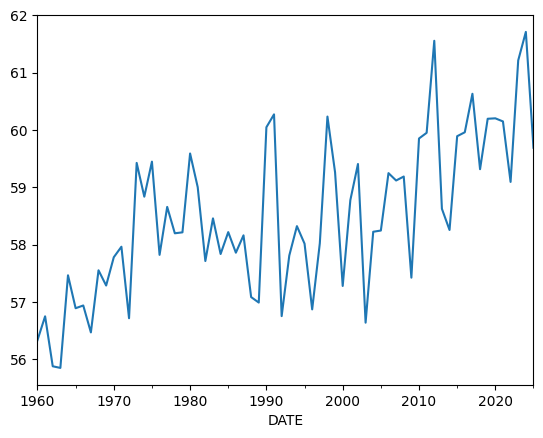

In [6]:
temp_annual_w.TAVG.plot()
plt.show()

### 6. Statistical Testing for Stationarity
We begin by applying the **Augmented Dickey-Fuller (ADF)** test to the raw temperature data. 

* **Objective**: To determine if the series is **stationary** by testing for the presence of a **unit root**. 
* **Note**: This helps us decide if the series has a stochastic trend that must be removed through differencing.

In [7]:
dfuller_test = adfuller(temp_annual_w['TAVG'])
print("The p-value for the ADF test is ", dfuller_test[1])

The p-value for the ADF test is  0.3917551806974217


##### Take first difference of the temperature Series

In [8]:
chg_temp = temp_annual_w['TAVG'].diff()
chg_temp = chg_temp.dropna()

##### Plot the ACF and PACF on the same page

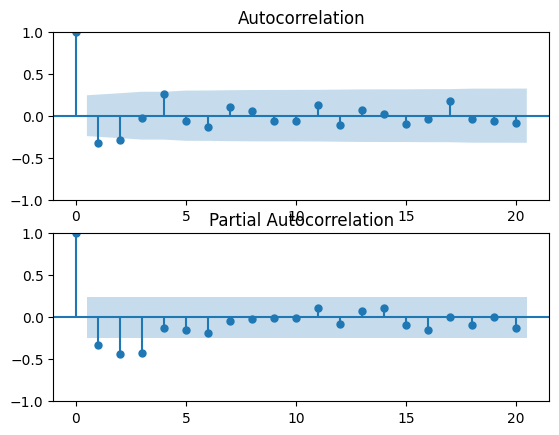

In [9]:
fig, axes = plt.subplots(2,1)
plot_acf(chg_temp, lags=20, ax=axes[0])
plot_pacf(chg_temp, lags=20, ax=axes[1])
plt.show()

##### Run the ARIMA models

In [29]:

mod_AR3 = ARIMA(chg_temp, order=(3,0,0))
res_AR3 = mod_AR3.fit()
print("The AIC for an AR(2) is", res_AR3.aic)

mod_MA1 = ARIMA(chg_temp, order=(0,0,1))
res_MA1 = mod_MA1.fit()
print("The AIC for an MA(1) is", res_MA1.aic)

The AIC for an AR(2) is 194.01823510284578
The AIC for an MA(1) is 194.18660564629366


##### Forecast temperature

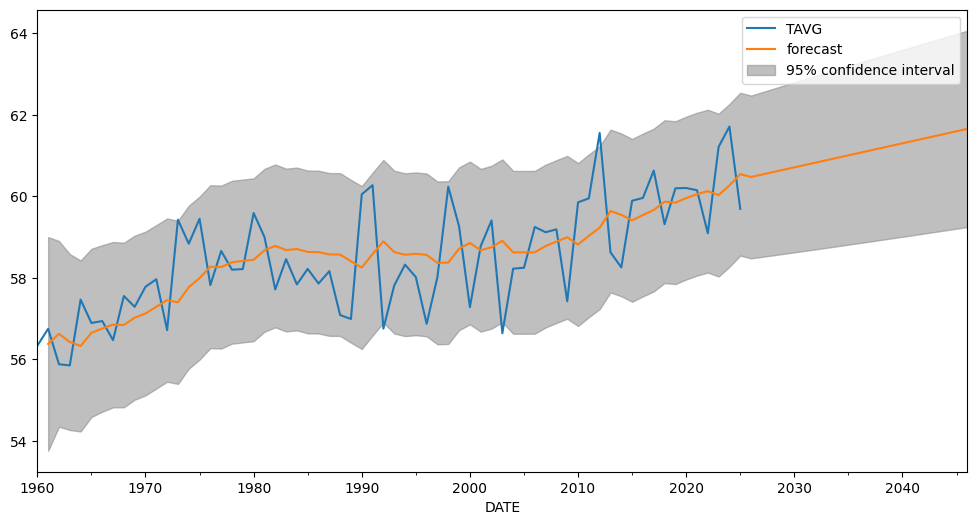

In [42]:

mod = ARIMA(temp_annual_w['TAVG'], trend='t', order=(1,0,1))
res = mod.fit()

fig, ax = plt.subplots(figsize=(12,6))

temp_annual_w['TAVG'].plot(ax=ax, label='TAVG')

plot_predict(
    res, start=pd.Period('1961', freq='Y'),
    end=pd.Period('2046', freq='Y'),
    ax=ax)
plt.legend()
plt.show()

                               SARIMAX Results                                
Dep. Variable:                   TAVG   No. Observations:                   66
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -94.093
Date:                Thu, 15 Jan 2026   AIC                            194.187
Time:                        17:08:24   BIC                            200.710
Sample:                    01-01-1960   HQIC                           196.760
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0589      0.021      2.864      0.004       0.019       0.099
ma.L1         -0.8496      0.072    -11.765      0.000      -0.991      -0.708
sigma2         1.0383      0.204      5.080      0.0

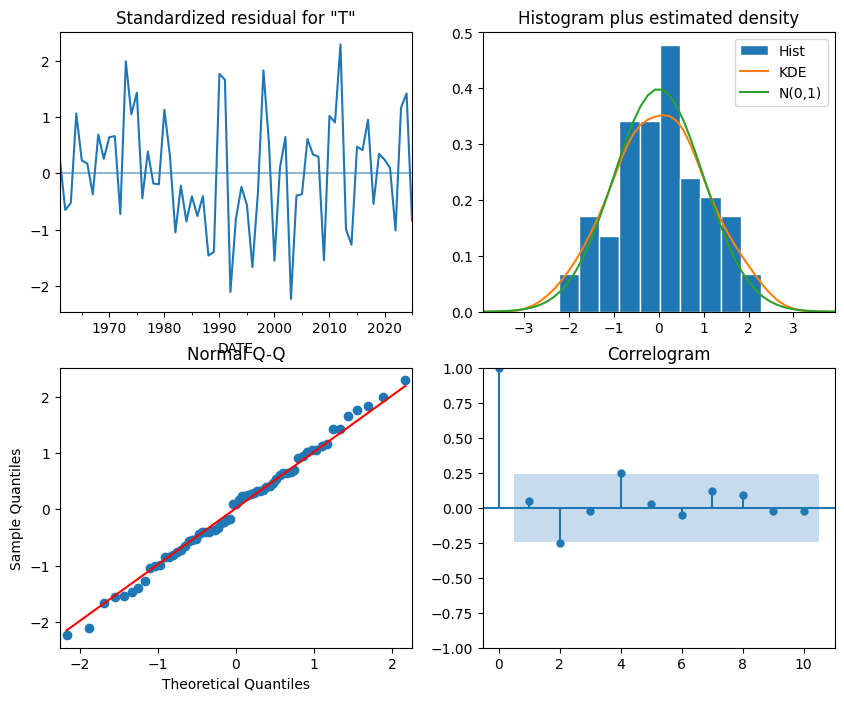

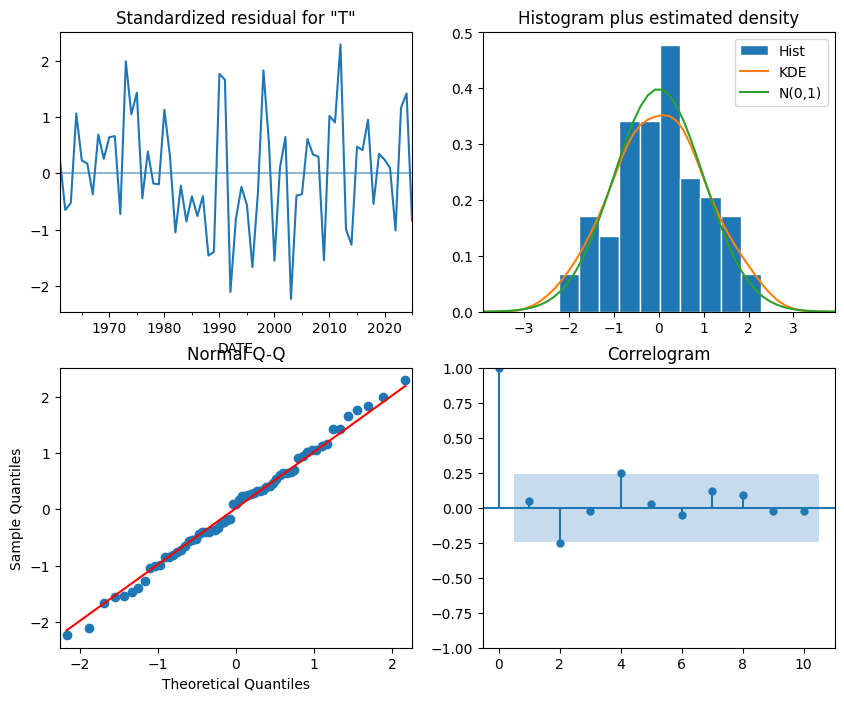

In [19]:
# 1. Mira si los coeficientes son estadísticamente significativos
print(res.summary())

# 2. Mira si el modelo dejó información sin explicar
res.plot_diagnostics(figsize=(10, 8))

In [35]:
print(type(temp_annual_w.index))
print(temp_annual_w.index.min(), temp_annual_w.index.max())
print(len(temp_annual_w))


<class 'pandas.core.indexes.period.PeriodIndex'>
1960 2025
66
